# **ML-Assisted Workflow for Reconnaissance Study on CO2 Storage Evaluation in Groningen Basin**
**Final Project**
GEOL558 - Luthfi Saifudin

## **Abstract**

The Groningen Field is a well-studied, prolific gas field in the Netherlands with 350 wells. The importance of rock characterization becomes apparent as the field progresses into the development phase where it utilizes CCS potential. An overview to determine where is the best place for CCS should be performed before jumping into more detailed analysis. Machine learning assisted workflow offers quick evaluation to delineate which area is most preferrable. The unsupervised learning applied to well log can help to rank reservoir quality based on its porosity, while supervised learning applied to seismic line can help to measure salt cap thickness. These integrated pipeline, aided by machine learing, can be applied to delineate potential reservoir CO2 storage, however, improving its accuracy can make it more reliable to be deployed in a real project.



### Requirements (packages needed to run the notebook)

In [1]:
#we need to import/install a few other things
import matplotlib.pyplot as plt
import lasio
from welly import Well, Project #loads the Well object definition from welly library. Multiple Wells can be stored in a Project.
import os, json
import glob
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from sys import stdout
import random
import matplotlib.image as mpimg
import segyio
import time
import joblib

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait as wait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException

from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans, AgglomerativeClustering
from catboost import CatBoostRegressor
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, silhouette_score, confusion_matrix
from xgboost import plot_importance
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

import plotly.express as px
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

path = os.getcwd()

In [2]:
# setup directory where the files stored
lasfiles_dir = 'LAS/'
welltops_dir = 'well_tops/'

## **Introduction**

The workflow is summarized in 4 simple steps:  

1.   **Dataset creation and loading**  
The well informations and tops are created by scraping [Netherland Oil and Gas Datacenter](https://www.nlog.nl/datacenter/). The 12 wireline logs and 3 PSDM seismic comes as a [petrel project](https://public.yoda.uu.nl/geo/UU01/1QH0MW.html) where we exported.  LAS files are loaded into the notebook using [welly](https://code.agilescientific.com/welly/). Data are then converted into pandas dataframe.
  
  
2.   **Data Preparation**  
Dealing with missing log  - Supervised ML  
The idea is to predict density and neutron log where the log is not available. We use supervised learning, taking advantage by building model from wells which have complete set of log, measure the accuracy between prediction and actual log. Then apply the same model to predict log in wells which have missing logs.  
  
  Preparing Seismic Dataset  
The supervised model need an interpretation as a variable to predict the salt structure. There are two data, clean data as uninterpreted seismic line, and masked data as manually-interpreted seismic line.
  
  
3.   **Model building and Deployment**  
Classifying Reservoir Properties on Well Log  - Unsupervised ML  
Explored number of clusters using shilloutte and elbow method. The model built using kMeans clustering.  
  
  Determine Salt Structure in Seismic - Supervised ML  
The model was built using Convolutional Neural Network in batch images.
  
  
4.   **Result**  
Calculating porous rock type ratio  
Clustered porosity then visualized as a pie chart to show the proportion of each rock type.  
  
  Measuring salt thickness  
Converting pixel length to depth and generate a set of thickness distribution along the seismic line.  
  
  The result than ranked based on salt thickness and preferred rocktype ratio. Best candidate will have high ratio of preferred rocktype and thick salt cap.

## **Dataset Creation**


In [3]:
##Make Download Directory
download_path = path + '/lithostratigraphy'

#Check if it exists, make if not
if os.path.exists(download_path):
    pass
else:
    os.makedirs(download_path)

#Set Up Driver with ChromeOptions
chromedriver = path + '/chromedriver.exe'
ser = Service(chromedriver)

chromeOptions = webdriver.ChromeOptions()

prefs = {"download.default_directory": download_path}
chromeOptions.add_experimental_option("prefs", prefs)

driver = webdriver.Chrome(service=ser, options=chromeOptions)

url = 'https://www.nlog.nl/datacenter/field-overview?lang=en'
driver.get(url)

### Look for Groningen Field data
Interact with web display and directly go to Groningen Field information

In [4]:
## Interacting with web elements
field = 'Groningen'
fields_search = driver.find_element(By.XPATH,'//*[@id="fieldsByName"]')
fields_search.click()

## Search for 'Groningen'
fields_search.clear()
fields_search.send_keys(field)

In [5]:
## Wait until all data are loaded and open a new frame
field_data = driver.find_element(By.LINK_TEXT, field)
field_data.click()
driver.switch_to.frame(driver.find_element(By.TAG_NAME, "iframe"))

In [6]:
## Store all wells Groningen Field into pandas dataframe
well_results = driver.find_element(By.CLASS_NAME,"well-table")
well_results_html = well_results.get_attribute('innerHTML')
well_df = pd.read_html(well_results_html)[0]
well_df.columns = well_df.columns.str.replace(' ', '_')
well_df.head()

,Well_name,Well_code
0,AMSWEER-01,AMR-01
1,AMSWEER-02,AMR-02
2,AMSWEER-03,AMR-03
3,AMSWEER-04,AMR-04
4,AMSWEER-05,AMR-05


### Pull lithostratigraphic data
Make function to do the job and make a loop to automate the process for all wells

In [7]:
def nlog_pull_lithostrat(well_name):
    '''
    Function to scrap lithostratigraphy data
    well_name : well name
    strat_df  : dataframe to store lithostratigraphic unit and its respective depth
    '''
    well_data = driver.find_element(By.LINK_TEXT, well_name)
    well_data.click()
    wait(driver, 10).until(EC.presence_of_element_located((By.XPATH,"//nlog-lithostrat-brh//div[@class='table-overflow']")))
    strat_results = driver.find_element(By.XPATH,"//nlog-lithostrat-brh//div[@class='table-overflow']")
    strat_results_html = strat_results.get_attribute('innerHTML')
    strat_df = pd.read_html(strat_results_html)[0]
    strat_df.columns = strat_df.columns.str.replace(' ', '_')
    strat_df = strat_df.drop_duplicates(subset=['Stratigrafical_unit'], keep='first') #sometimes it has duplicate unit, we keep the first record
    strat_df = strat_df[['Stratigrafical_unit','Top_(m)']].set_index('Stratigrafical_unit') #simplify to consists only stratigraphic name and top depth
    driver.execute_script("window.history.go(-1)")#driver.back()
    wait(driver, 10).until(EC.presence_of_element_located((By.LINK_TEXT, well_name)))
    time.sleep(1)
    return strat_df

def nlog_pull_wellinfo(well_name):
    '''
    Function to scrap well information
    well_name : well name
    well_info  : dictionary of well information
    '''
    well_data = driver.find_element(By.LINK_TEXT, well_name)
    well_data.click()
    wait(driver, 10).until(EC.presence_of_element_located((By.XPATH,"//nlog-identify-brh//div[@class='p-tabview-panel']")))
    info_results = driver.find_element(By.XPATH,"//nlog-identify-brh//div[@class='p-tabview-panel']")
    info_results_html = info_results.get_attribute('innerHTML')
    well_info = pd.read_html(info_results_html)[0]
    well_info[well_info.columns[0]] = well_info[well_info.columns[0]].map(lambda x: x.rstrip(':'))
    well_info = well_info.set_index(well_info.columns[0])
    well_info = well_info.squeeze().to_dict()
    driver.execute_script("window.history.go(-1)")#driver.back()
    wait(driver, 10).until(EC.presence_of_element_located((By.LINK_TEXT, well_name)))
    time.sleep(1)
    return well_info

It will take about 20 minutes to download 325 wells data

In [8]:
## Iterate through the list of Groningen Field wells and save the lithostratigraphic data into json files for each well
for i in range(len(well_df)):
    try:
        strat_df = nlog_pull_lithostrat(well_df.Well_name[i])
        strat_df.squeeze().to_json(download_path + '/' + well_df.Well_code[i] + '.json', indent=1)
        stdout.write("\r%s" % well_df.Well_name[i])
        stdout.flush()
    except TimeoutException as e:
        print(well_df.Well_name[i] + ": Data not found")
        driver.execute_script("window.history.go(-1)")
        wait(driver, 10).until(EC.presence_of_element_located((By.LINK_TEXT, well_df.Well_name[i])))
        time.sleep(1)

OVERSCHILD-04A-09OVERSCHILD-05: Data not found
TEN POST-0906TEN POST-10: Data not found
SCHEEMDERZWAAG-102SCHEEMDERZWAAG-103: Data not found
SCHEEMDERZWAAG-104SCHEEMDERZWAAG-105: Data not found
ZUIDERVEEN-1312-10

In [9]:
## Iterate through the list of Groningen Field wells and save well informations
well_data = pd.DataFrame()
for i in range(len(well_df)):
    try:
        well_info = nlog_pull_wellinfo(well_df.Well_name[i])
        well_data = pd.concat([well_data, pd.DataFrame.from_records([well_info])])
        stdout.write("\r%s" % well_df.Well_name[i])
        stdout.flush()
    except TimeoutException as e:
        print(well_df.Well_name[i] + ": Data not found")
        driver.execute_script("window.history.go(-1)")
        wait(driver, 10).until(EC.presence_of_element_located((By.LINK_TEXT, well_df.Well_name[i])))
        time.sleep(1)

ZUIDERVEEN-1312-10

In [10]:
#Restructure the dataset
well_data[well_data.columns[1]] = well_data[well_data.columns[1]].map(lambda x: x.rstrip('(WGS84)'))
location = well_data['Location'].str.split(", ", n = 1, expand = True)
well_data['Lat'] = pd.to_numeric(location[0])
well_data['Lon'] = pd.to_numeric(location[1])
well_data[well_data.columns[2]] = well_data[well_data.columns[2]].map(lambda x: x.rstrip('(RD)'))
well_data['End depth'] = well_data['End depth'].str.extract('(\d+)', expand=False)
well_data['End depth'] = pd.to_numeric(well_data['End depth'])
well_data['Startdate drilling'] = pd.to_datetime(well_data['Startdate drilling'], format='%d-%m-%Y')
well_data.to_csv('well_data.csv')
well_data.head(5)

,Identification,Location,Delivered location,Operator,Startdate drilling,Enddate drilling,Well type,Status,Well result,End depth,Vertical position of Rotary Table,Trajectory,Actual vertical depth,Deviation in direction x,Deviation in direction y,Platform/installation,Drilling company,Field (fieldcode),Lat,Lon
0,AMR-01,"53.30083055, 6.90509971","256193, 591550",Nederlandse Aardolie Maatschappij B.V.,1972-03-27,14-05-1972,Appraisal hydrocarbon,Producing/Injecting,Gas,2974,5.09 meter relative to NAP,Vertical,2971.55 meter relative to Rotary Table2966.46 ...,61.90 m,45.01 m,Ideal 80 B,Deutag,Groningen (GRO),53.30083055,6.90509971
0,AMR-02,"53.30021133, 6.90929329","256474, 591487",NAM,1973-05-16,12-06-1973,Development hydrocarbon,Producing/Injecting,Gas,3002,5.84 meter relative to NAP,Deviated,2975.50 meter relative to Rotary Table2969.66 ...,173.87 m,159.57 m,NaN,NaN,Groningen (GRO),53.30021133,6.90929329
0,AMR-03,"53.30020666, 6.90824303","256404, 591485",NAM,1973-01-25,23-02-1973,Development hydrocarbon,Producing/Injecting,Gas,3011,5.11 meter relative to NAP,Deviated,2976.23 meter relative to Rotary Table2971.12 ...,232.15 m,151.18 m,NaN,KCA Deutag Drilling Ltd,Groningen (GRO),53.30020666,6.90824303
0,AMR-04,"53.30020217, 6.90719863","256334.39, 591483.03",NAM,1973-02-24,21-03-1973,Development hydrocarbon,Closed-in,Gas,3015,5.10 meter relative to NAP,Deviated,2973.52 meter relative to Rotary Table2968.42 ...,272.95 m,148.59 m,NaN,KCA Deutag Drilling Ltd,Groningen (GRO),53.30020217,6.90719863
0,AMR-05,"53.30019729, 6.90614251","256264, 591481",NAM,1973-03-22,07-04-1973,Development hydrocarbon,Plugged back and sidetracked,Technical failure,2584,5.19 meter relative to NAP,Deviated,2576.90 meter relative to Rotary Table2571.71 ...,35.52 m,77.79 m,NaN,NaN,Groningen (GRO),53.30019729,6.90614251


### Exploratory Data Analysis
Some visualization and statistics. 

Since we already store all data as a json format in a folder, we load it in again and combine them all as a pandas dataframe. The json file itself can be used for other purpose independently.

In [11]:
## Load data
welltops_files = os.path.join(download_path,'*.json')
file_list = glob.glob(welltops_files)
welltops = pd.DataFrame()


for file in file_list:
    temp = pd.read_json(file, orient='index').reset_index() #read each json file, contains tops data
    temp.insert(loc=0, column='Well', value=Path(file).stem) #assign well name
    welltops = welltops.from_records(temp) #collect into one dataframe

welltops = welltops.set_axis(['Well', 'Surface', 'Depth'], axis=1, inplace=False)
welltops.head(5)

,Well,Surface,Depth
0,ZVN-13,Upper North Sea Group,0.0
1,ZVN-13,Brussels Sand Member,496.0
2,ZVN-13,Ieper Member,555.0
3,ZVN-13,Basal Dongen Tuffite Member,730.0
4,ZVN-13,Landen Clay Member,746.0


Text(0, 0.5, 'Well Result')

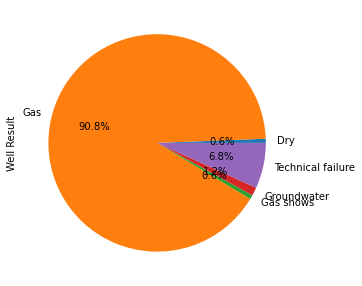

In [12]:
#Looking at the distribution of well result
well_data.groupby(['Well result']).size().plot(kind = 'pie', figsize=(5,5),autopct='%1.1f%%')
plt.ylabel('Well Result')

Text(0, 0.5, 'Number of well')

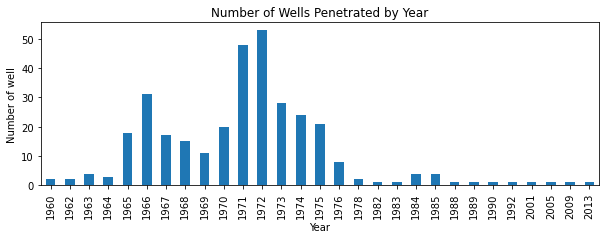

In [13]:
#Looking at the distribution of well penetration by year
well_data.groupby(well_data['Startdate drilling'].dt.year)['Startdate drilling'].size().plot(kind = 'bar', figsize=(10,3))
plt.title('Number of Wells Penetrated by Year')
plt.xlabel('Year')
plt.ylabel('Number of well')

Text(119.70915246879721, 0.5, 'Latitude')

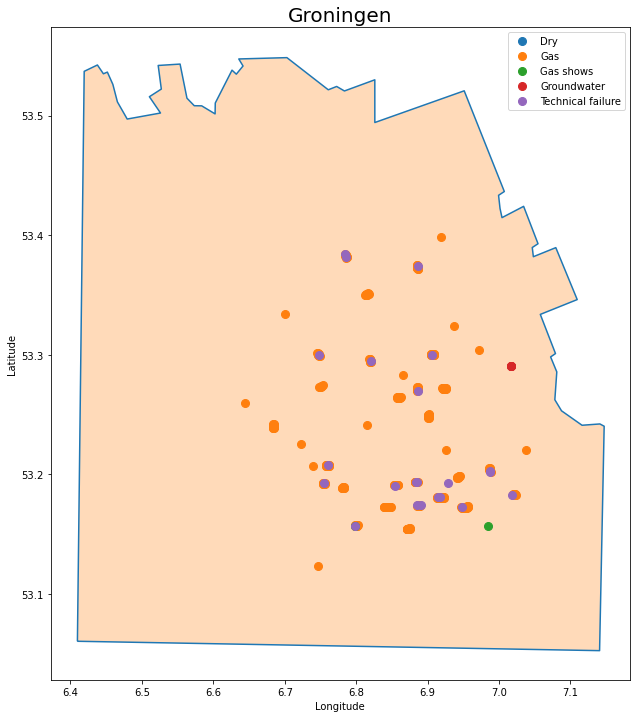

In [14]:
#Plot well locations
groups = well_data.groupby('Well result')
mapdf = gpd.read_file('Groningen_Field.zip').to_crs(4326)
#mapdf = mapdf[(mapdf["TYPE_1"] == "Provincie") & (mapdf["NAME_1"] == "Groningen")]
fig, ax = plt.subplots(figsize=(12,12))
mapdf.plot(ax=ax,facecolor='peachpuff')
for name, group in groups:
    ax.plot(group.Lon, group.Lat, marker='o', linestyle='', ms=8, label=name)
ax.legend()
plt.title('Groningen', fontsize=20)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

## **Data Preparation**
The supervised learning is effective to predict a missing log. I choose the xgregressor and catboost because the fact that we work with continuous dataset (as a well log) and it is pretty fast to build a model and easy to tune. I also use GridSearch to automate the process of picking the right parameter, although if I have more resources I can try wider range of parameters. The R2 score is pretty straightforward to display how accurate our model is.

This method is really applicable for people who works with well log data and got a missing log in their dataset due to some circumstances. Sometimes a company will not run a specific wireline log because it is not a priority (and cut the price), but turns out that we need this specific log eventually as the field evolve and needs a better analysis which then needs a complete set of wireline log. Using supervised ML can solve this case.



### Importing our well log data

In [15]:
wells = Project.from_las(os.path.join(lasfiles_dir,'*'))
wells

12it [00:05,  2.28it/s]


Index,UWI,Data,Curves
0,11000075023501,5 curves,"NEUT, DENS, SON, GR, RESD"
1,11000080297602,6 curves,"NEUT, DENS, SON, GR, CALI, RESD"
2,11000080319501,5 curves,"NEUT, DENS, SON, GR, RESD"
3,11000080031301,5 curves,"NEUT, DENS, SON, GR, RESD"
4,11000075018101,8 curves,"DENS, SON, GR, CALI, RESM, RESD, VCL_2014, FACIES"
5,11000081099702,8 curves,"SON, GR, CALI, RESS, RESM, RESD, VCL_2014, FACIES"
6,11000080295801,5 curves,"NEUT, DENS, SON, GR, RESD"
7,11000075034301,4 curves,"SON, DENS, GR, RESD"
8,11000080299701,5 curves,"RESD, DENS, SON, GR, NEUT"
9,11000075025402,8 curves,"DENS, SON, GR, CALI, RESM, RESD, VCL_2014, FACIES"


Now we have welly imported, we'll load our well data in the form of an LAS file.

We see that well number 7 and 10 do not have NEUT log, and all wells have GR, SON, and some have DENS log. We want to predict NEUT log in well 7 and 10 using supervised learning. I try to play with XGboost and CatBoost as it highly efffective and deal with imbala. I will take 7 wells to divide as training-test set, then predict in other 2 wells as a blind test. After that, the model will be utilized to predict NEUT log in well number 7 and 10. This also applied for Density log prediction.

### Store all well log data in a single pandas dataframe

In [16]:
alias = {'Depth': ['DEPT'], 
         'UWI' : ['UWI'],
         'Gamma': ['GR'], 
         'Sonic': ['SON'], 
         'Caliper': ['CALI'], 
         'Resistivity': ['RESD'],
         'Density':['DENS'],
         'Neutron':['NEUT']
        }

keys = ['UWI', 'Depth', 'Gamma', 'Sonic','Density','Neutron', 'Caliper', 'Resistivity']

wells_df = wells.df(keys=keys, alias=alias)

#make depth and UWI columns, not indexes
wells_df.reset_index(inplace=True)
wells_df = wells_df.rename(columns = {'DEPT':'Depth'})

#drop depths less than 2650ft because we want to focus on Rotliegend Fm.
wells_df.drop(wells_df[wells_df['Depth'] <= 2650].index, inplace = True)

#calculate well numbers
well_num = len(wells_df.UWI.unique())

#assign well name complementing UWI
for i in range(well_num):
  wells_df.loc[wells_df.UWI == wells[i].uwi, ['Well']] = wells[i].name.replace(' ', '')

wells_df.head(5)

,UWI,Depth,Gamma,Sonic,Density,Neutron,Resistivity,Caliper,Well
2620,11000075023501,2650.022800446,26.8216941950,70.5710818373,2.0186095125,NaN,581.0446840992,NaN,HND-1
2621,11000075023501,2651.022800446,15.9010891785,70.5120241521,2.0647622725,NaN,642.9485020299,NaN,HND-1
2622,11000075023501,2652.022800446,12.2713791175,70.3990309133,2.0228251256,NaN,563.6552491824,NaN,HND-1
2623,11000075023501,2653.022800446,16.7124988290,69.9336540890,2.0952882814,NaN,612.0825307105,NaN,HND-1
2624,11000075023501,2654.022800446,13.6056986145,69.5201853435,2.0904838352,NaN,486.1309607407,NaN,HND-1


In [17]:
wells_df.describe()

,Depth,Gamma,Sonic,Density,Neutron,Resistivity,Caliper
count,9591.0000000000,9556.0000000000,9433.0000000000,8537.0000000000,4558.0000000000,6.4630000000e+03,2786.0000000000
mean,3156.8637935481,60.1154260844,70.3599018845,2.3894171872,0.1024214937,9.5438181191e+03,8.1450677728
std,395.6988449090,39.2578366403,8.7953589399,0.2837191163,0.1020927742,3.5212219048e+05,1.5861741607
min,2650.0228004460,3.3941204892,44.7983016970,1.4092771657,-0.0312200000,1.0199999810e-01,4.3966999054
25%,2852.0000000000,32.0807485580,67.1439971920,2.0780000687,-0.0166000000,2.2797523093e+00,7.7325583782
50%,3075.0000000000,45.2975298635,68.6979980470,2.4149422592,0.1304170378,8.7805995941e+00,8.3575000763
75%,3352.7410278200,92.6956233978,75.0177864355,2.6202202815,0.1718367487,1.2140355224e+03,8.8440499306
max,4475.0000000000,252.1723765096,138.2589748054,3.0139112969,0.6665599942,2.0000000000e+07,12.8870000840


In [18]:
#We need Gamma and Sonic log to predict density and neutron log
wells_df = wells_df[wells_df['Gamma'].notna() & wells_df['Sonic'].notna()]

### Predict Density

In [19]:
#set well which we want to assign as blind test and the wells which does not have a real RHOB log
well_model = ['11000075023501','11000080297602','11000080319501','11000075018101','11000080031301','11000080299701','11000080295801']
well_blindtest = ['11000075025001','11000074117801']
well_predict = ['11000081099702']

wells_filtered = wells_df[['Well','UWI','Depth','Gamma','Sonic','Density']]
wells_model = wells_filtered[wells_filtered['UWI'].isin(well_model)].dropna()
wells_blindtest = wells_filtered[(wells_filtered['UWI'].isin(well_blindtest)) & (wells_filtered['Density'].notna())]
wells_predict = wells_filtered[wells_filtered['UWI'].isin(well_predict)]

In [20]:
#splitting train and test, we choose GammaRay, Sonic, and Density as predictor. Neutron log as target.
#Trying to use CatBoostRegressor
X, y = wells_model.iloc[:, 3:-1], wells_model.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
dens_cat_reg=CatBoostRegressor(eval_metric ='RMSE',
                               learning_rate = 0.015,
                               n_estimators = 200,
                               depth = 4,
                               verbose=0)

#fit and predict
dens_cat_reg.fit(X_train, y_train)
predictions = dens_cat_reg.predict(X_test)

R2 = r2_score(y_test, predictions)
print("The score is %.5f" % R2)

The score is 0.75142


In [21]:
#Trying to use XGBRegressor
X, y = wells_model.iloc[:, 3:-1], wells_model.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
dens_xgb_regressor=xgb.XGBRegressor(eval_metric ='rmse',
                           learning_rate = 0.015,
                           n_estimators = 200,
                           max_depth = 4)

#fit and predict
dens_xgb_regressor.fit(X_train, y_train)
predictions = dens_xgb_regressor.predict(X_test)

R2 = r2_score(y_test, predictions)
print("The score is %.5f" % R2)

The score is 0.66830


With similar parameters, CatBoostRegressor performs better than XGBRegressor. We proceed to tune the hyperparameter of CatBoostRegressor.

In [22]:
dens_regressor = dens_cat_reg

#looking for the best parameter using GridSearch
param_grid = {"depth":    [3, 4, 5, 6],
              "n_estimators": [200, 400, 600, 800],
              "learning_rate": [0.015, 0.01, 0.005]}

# try out every combination of values
search = GridSearchCV(dens_regressor, param_grid, cv=5).fit(X_train, y_train)
print("The best hyperparameters are ",search.best_params_)

The best hyperparameters are  {'depth': 6, 'learning_rate': 0.01, 'n_estimators': 800}


In [23]:
#Let's use the best parameter to tune our model
dens_regressor = CatBoostRegressor(eval_metric ='RMSE',
                               learning_rate = 0.01,
                               n_estimators = 800,
                               depth = 6,
                               verbose=0)

#fit and predict
dens_regressor.fit(X_train, y_train)
predictions = dens_regressor.predict(X_test)

R2 = r2_score(y_test, predictions)
print("The score is %.5f" % R2)

The score is 0.76046


In [24]:
#Try to predict for an unseen dataset
wells_blindtest = wells_blindtest.assign(Density_pred = dens_regressor.predict(wells_blindtest.loc[:, ('Gamma','Sonic')]))
R2 = r2_score(wells_blindtest['Density'], wells_blindtest['Density_pred'])
print("The prediction score is %.5f" % R2)

#Compare with Gardner
wells_blindtest.loc[:,'Density_gardner']=0.23*(wells_blindtest.loc[:,'Sonic']**0.25)
R2 = r2_score(wells_blindtest['Density'], wells_blindtest['Density_gardner'])
print("The Gardner score is %.5f" % R2)

The prediction score is 0.77351
The Gardner score is -45.85246


It seems that a lot of factors might influence which constant should we choose to accurately derive density frorm sonic log, which in this case I do not have enough capability to decide the constant.

In [25]:
# Create the figure and subplots
def triple_combo_plot(logs):
    if('RockType' in logs.columns):
        fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(10,12), sharey=True)
    elif ('Neutron' in logs.columns):
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8,12), sharey=True)
    else:
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(5,12), sharey=True)        
    fig.suptitle(logs.Well.values[0], fontsize=12)
    fig.subplots_adjust(top=0.8,wspace=0.1)

#General setting for all axis
    for axes in ax:
        axes.invert_yaxis()
        axes.yaxis.grid(True)
        ax[0].set_ylabel('Depth (m)')
        axes.get_xaxis().set_visible(False) 
    
        
#1st track: GR
    ax01 = ax[0].twiny()
    ax01.set_xlim(0,150)
    ax01.plot(logs.Gamma, logs.Depth, label='GR[api]', color='green') 
    ax01.spines['top'].set_position(('outward',0))
    ax01.set_xlabel('GR[api]',color='green') 
    ax01.tick_params(axis='x', colors='green')
    
#2nd track: SON, DENS

    ax11 = ax[1].twiny()
    ax11.set_xlim(140,40)
    ax11.spines['top'].set_position(('outward',0))
    ax11.set_xlabel('DT[us/ft]')
    ax11.plot(logs.Sonic, logs.Depth, label='DT[us/ft]', color='blue')
    ax11.set_xlabel('DT[us/ft]', color='blue')    
    ax11.tick_params(axis='x', colors='blue')

    if('Density' in logs.columns):
        ax12 = ax[1].twiny()
        ax12.set_xlim(1.95,2.95)
        ax12.plot(logs.Density, logs.Depth ,label='RHOB[g/cc]', color='red') 
        ax12.spines['top'].set_position(('outward',40))
        ax12.set_xlabel('RHOB[g/cc]',color='red')
        ax12.tick_params(axis='x', colors='red')
    
    if('Density_pred' in logs.columns):
        ax13 = ax[1].twiny()
        ax12.set_xlim(1.95,2.95)
        ax12.plot(logs.Density_pred, logs.Depth ,label='RHOB_pred[g/cc]', color='purple', linestyle='dashed') 
        ax12.spines['top'].set_position(('outward',80))
        ax12.set_xlabel('RHOB_pred[g/cc]',color='purple')
        ax12.tick_params(axis='x', colors='purple')

    if('Density_gardner' in logs.columns):
        ax12 = ax[1].twiny()
        ax12.set_xlim(1.95,2.95)
        ax12.plot(logs.Density_pred, logs.Depth ,label='RHOB_gardner[g/cc]', color='green', linestyle='dashed') 
        ax12.spines['top'].set_position(('outward',120))
        ax12.set_xlabel('RHOB_gardner[g/cc]',color='green')
        ax12.tick_params(axis='x', colors='green')

#3rd track: NEUT, NEUT prediction

    if('Neutron' in logs.columns):
        ax21 = ax[2].twiny()
        ax21.set_xlim(-0.15,0.45)
        ax21.invert_xaxis()
        ax21.plot(logs.Neutron, logs.Depth, label='NPHI[%]', color='green') 
        ax21.spines['top'].set_position(('outward',0))
        ax21.set_xlabel('NPHI[%]', color='green')    
        ax21.tick_params(axis='x', colors='green')
    
    if('Neutron_pred' in logs.columns):
        ax22 = ax[2].twiny()
        ax22.set_xlim(-0.15,0.45)
        ax22.invert_xaxis()
        ax22.plot(logs.Neutron_pred, logs.Depth, label='NPHI_pred[%]', color='purple', linestyle='dashed') 
        ax22.spines['top'].set_position(('outward',40))
        ax22.set_xlabel('NPHI_pred[%]', color='purple')    
        ax22.tick_params(axis='x', colors='purple')
        
#4th track
    if('RockType' in logs.columns):
        ax31 = ax[3].twiny()
        ax31.set_xlim(0,5)
        ax31.plot(logs.RockType, logs.Depth, label='RockType', color='black') 
        ax31.spines['top'].set_position(('outward',0))
        ax31.set_xlabel('RockType', color='green')    
        ax31.tick_params(axis='x', colors='green')

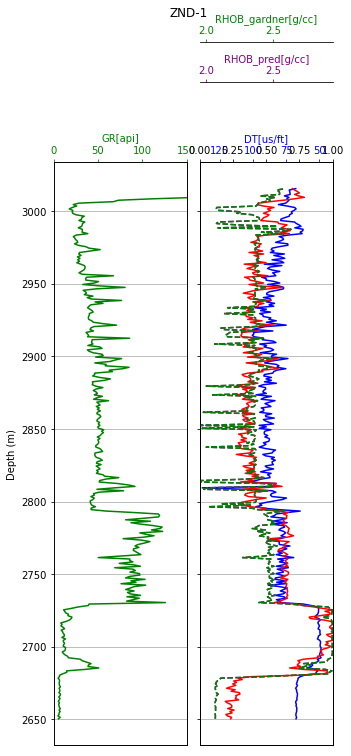

In [26]:
#Plot the result
well_plot = wells_blindtest.loc[wells_blindtest['UWI']=='11000074117801']
triple_combo_plot(well_plot)

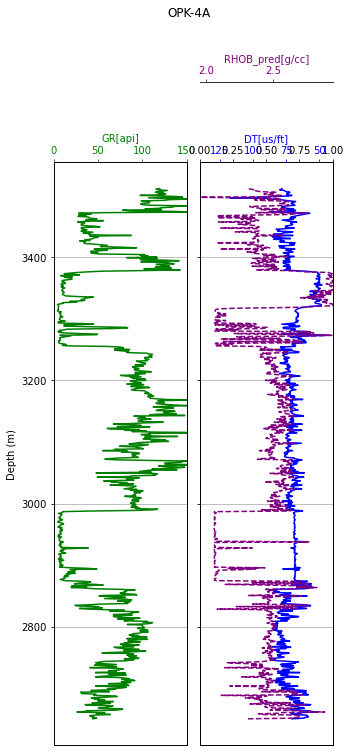

In [27]:
#Try to predict for a real case
wells_predict=wells_predict.assign(Density_pred = dens_regressor.predict(wells_predict.loc[:, ('Gamma','Sonic')]))

#Plot the result
well_plot = wells_predict
triple_combo_plot(well_plot)

In [28]:
#save density model
dens_regressor.save_model('dens_regressor.model')

#load model
# dens_regressor=xgb.XGBRegressor()
# dens_regressor.load_model('dens_regressor.model')

### Predict Neutron Log

In [29]:
#set well which we want to assign as blind test and the wells which does not have a real NEUT log
well_model = ['11000075023501','11000080297602','11000080319501','11000075018101','11000080031301','11000080299701','11000080295801']
well_blindtest = ['11000075025001','11000074117801']
well_predict = ['11000075034301','11000075025402']

wells_filtered = wells_df[['Well','UWI','Depth','Gamma','Sonic','Density','Neutron']]
wells_model = wells_filtered[wells_filtered['UWI'].isin(well_model)].dropna()
wells_blindtest = wells_filtered[(wells_filtered['UWI'].isin(well_blindtest)) & (wells_filtered['Neutron'].notna())]
wells_predict = wells_filtered[wells_filtered['UWI'].isin(well_predict)]

In [30]:
#splitting train and test, we choose GammaRay, Sonic, and Density as predictor. Neutron log as target.
#Trying to use CatBoostRegressor
X, y = wells_model.iloc[:, 3:-1], wells_model.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
nphi_cat_reg=CatBoostRegressor(eval_metric ='RMSE',
                               learning_rate = 0.015,
                               n_estimators = 200,
                               depth = 4,
                               verbose=0)

#fit and predict
nphi_cat_reg.fit(X_train, y_train)
predictions = nphi_cat_reg.predict(X_test)

R2 = r2_score(y_test, predictions)
print("The score is %.5f" % R2)

The score is 0.85121


In [31]:
#splitting train and test, we choose GammaRay, Sonic, and Density as predictor. Neutron log as target.
X, y = wells_model.iloc[:, 3:-1], wells_model.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
nphi_regressor=xgb.XGBRegressor(eval_metric ='rmse',
                           learning_rate = 0.015,
                           n_estimators = 200,
                           max_depth = 4)

#fit and predict
nphi_regressor.fit(X_train, y_train)
predictions = nphi_regressor.predict(X_test)

R2 = r2_score(y_test, predictions)
print("The score is %.5f" % R2)

The score is 0.79985


Apparently CatBoostRegressor also performs better for Neutron log prediction

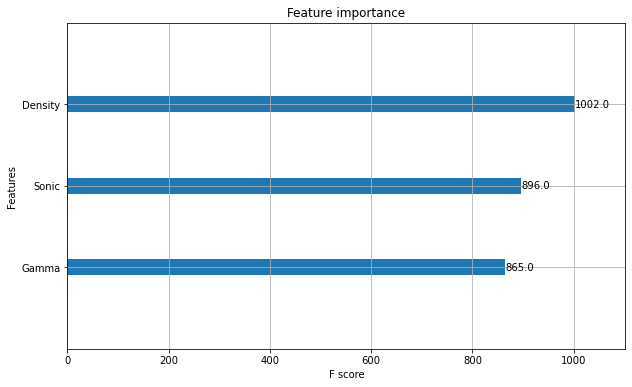

In [33]:
#Trying to look at which parameter matters the most
fig, ax = plt.subplots(figsize=(10,6))
plot_importance(nphi_regressor, max_num_features=8, ax=ax)
plt.show();

Density is the most important feature to predict neutron log

In [35]:
#looking for the best parameter using GridSearch
param_grid = {"depth":    [3, 4, 5, 6],
              "n_estimators": [200, 400, 600, 800],
              "learning_rate": [0.015, 0.01, 0.005]}

# try out every combination of values
search = GridSearchCV(nphi_cat_reg, param_grid, cv=5).fit(X_train, y_train)

print("The best hyperparameters are ",search.best_params_)

The best hyperparameters are  {'depth': 6, 'learning_rate': 0.015, 'n_estimators': 800}


Turns out we can go with faster learning rate without sacrificing the results. We also increase the max_depth and n_estimators to make a better prediction.

In [36]:
#Let's use the best parameter to tune our model
nphi_regressor=CatBoostRegressor(eval_metric ='RMSE',
                                 learning_rate = 0.015,
                                 n_estimators = 800,
                                 depth = 6,
                                 verbose=0)

#fit and predict
nphi_regressor.fit(X_train, y_train)
predictions = nphi_regressor.predict(X_test)

R2 = r2_score(y_test, predictions)
print("The score is %.5f" % R2)

The score is 0.85188


We have better score now which imply that the GridSearch method can help to pick better parameter than we use previously.

In [37]:
#Try to predict for an unseen dataset
wells_blindtest = wells_blindtest.assign(Neutron_pred = nphi_regressor.predict(wells_blindtest.loc[:, ('Gamma', 'Sonic', 'Density')]))
R2 = r2_score(wells_blindtest['Neutron'], wells_blindtest['Neutron_pred'])
print("The score is %.5f" % R2)

The score is 0.85808


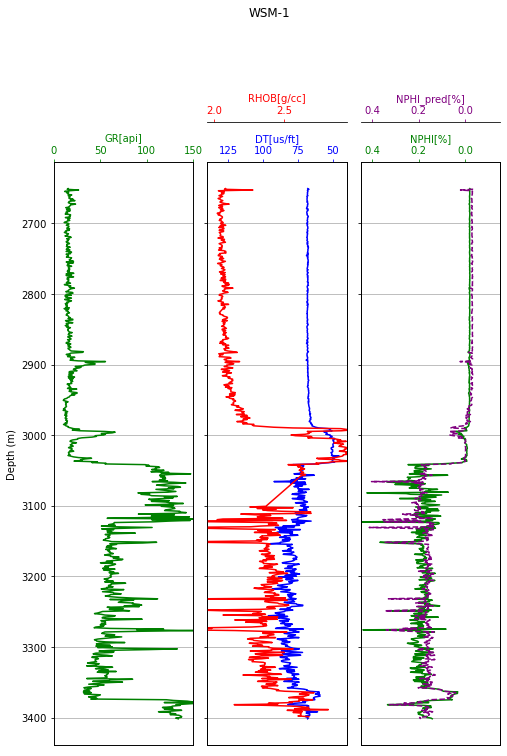

In [38]:
#plotting log and look whether the prediction works
well_plot = wells_blindtest[wells_blindtest.UWI=='11000075025001']
triple_combo_plot(well_plot)

As we can see the purple prediction curve align well with the actual neutron green log. The R2 score we got in the model building phase using the best parameter is 0.851 and 0.854 in blind test, which is relatively accurate. Thus, we can move to the next step where we use the model to predict neutron log for a real case.

Try to use the model to predict Neutron log where the log is not available

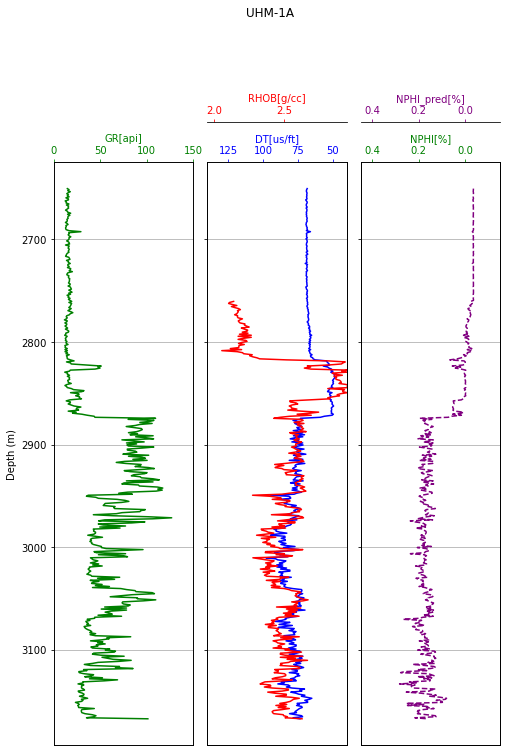

In [39]:
#Try to predict for a real case
wells_predict = wells_predict.assign(Neutron_pred = nphi_regressor.predict(wells_predict.loc[:, ('Gamma', 'Sonic', 'Density')]))

#Plot the result
well_plot = wells_predict[wells_predict.UWI=='11000075025402']
triple_combo_plot(well_plot)

In [40]:
#save model
nphi_regressor.save_model('nphi_regressor.model')

## Model Building and Deployment

### Classifying Reservoir Properties on Well Log - Unsupervised ML

In [41]:
#Importing welltops
welltops_files = os.path.join(welltops_dir,'*.json')
file_list = glob.glob(welltops_files)
welltops = pd.DataFrame()


for file in file_list:
    temp = pd.read_json(file, orient='index').reset_index() #read each json file, contains tops data
    temp.insert(loc=0, column='Well', value=Path(file).stem) #assign well name
    welltops = pd.concat([welltops,temp], ignore_index = True) #collect into one dataframe

welltops = welltops.set_axis(['Well', 'Surface', 'Depth'], axis=1, inplace=False)
welltops.head(5)

,Well,Surface,Depth
0,HND-1,RO_T_Upper Rotliegend Group_TOP,2878.50
1,HND-1,ROSLU3.1_T_Upper Slochteren_Zone_3.1_TOP,2940.22
2,HND-1,ROSLL1_B_Lower Slochteren_Zone_1_BASE,3138.08
3,KWR-1A,RO_T_Upper Rotliegend Group_TOP,3280.00
4,KWR-1A,ROSLU3.1_T_Upper Slochteren_Zone_3.1_TOP,3309.20


We crop the data to include only Rotliegend Fm., the potential reservoir interval

In [42]:
#Include only Rotliegend Fm. interval
wells_df_prep = wells_df
welltop_Rotliegend = welltops.loc[welltops['Surface'] == 'RO_T_Upper Rotliegend Group_TOP'].reset_index()
wells_ready = pd.DataFrame()

#drop depths above Rotliegend Fm.
for i in range(len(welltop_Rotliegend)):
    top = welltop_Rotliegend.loc[i, 'Depth']
    wells_cut = wells_df_prep[(wells_df_prep['Depth'] >= top) & (wells_df_prep['Well']==welltop_Rotliegend.loc[i, 'Well'])]
    wells_cut.describe()
    wells_ready = pd.concat([wells_ready,wells_cut])

In [43]:
#Use the previous model to fill in the missing log
wells_ready.loc[:,'Density_pred']=dens_regressor.predict(wells_ready.loc[:, ['Gamma','Sonic']])
wells_ready['Density'] = wells_ready['Density'].fillna(wells_ready.pop('Density_pred'))
wells_ready.loc[:,'Neutron_pred']=nphi_regressor.predict(wells_ready.loc[:, ['Gamma','Sonic','Density']])
wells_ready['Neutron'] = wells_ready['Neutron'].fillna(wells_ready.pop('Neutron_pred'))
wells_ready.describe()

,Depth,Gamma,Sonic,Density,Neutron,Resistivity,Caliper
count,3581.0000000000,3581.0000000000,3581.0000000000,3581.0000000000,3581.0000000000,3581.0000000000,1093.0000000000
mean,3363.1109014643,73.8319994411,75.9914306024,2.4984838054,0.1684483987,5.2535307181,7.1949254378
std,446.7041542813,37.0743486831,7.7494713609,0.1521079145,0.0579436736,12.3184688359,1.6392790823
min,2665.7919922000,17.5260528738,50.8989982600,1.4092771657,-0.0293014983,0.1019999981,4.5367999077
25%,3046.0228004460,43.5019989010,70.1940002440,2.3900001049,0.1370952518,0.9739999771,6.0149998665
50%,3256.6820068400,63.0123246401,75.6308592719,2.4939999580,0.1625906574,3.2003565920,6.5999999046
75%,3513.5383911100,102.0768786924,81.0570363555,2.6285958025,0.1909936831,6.9185792088,8.3570003510
max,4472.0000000000,214.1589965800,138.2589748054,2.8584050100,0.6665599942,568.4169921900,11.5089998250


In [44]:
#Define porosity log
X = wells_ready[['Density','Neutron']]

Determine how many cluster should we have to classify the porosity

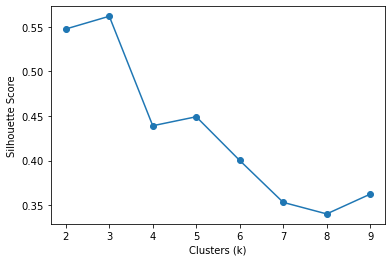

In [45]:
#silhouette method
k = list(range(2,10))
score=[]

for n_cluster in k:
    km = KMeans(n_clusters=n_cluster).fit(X)
    silhouette_avg = silhouette_score(X, km.labels_)
    score.append(silhouette_score(X, km.labels_))
    
plt.plot(k, score, 'o-')
plt.xlabel("Clusters (k)")
plt.ylabel("Silhouette Score")
plt.show()

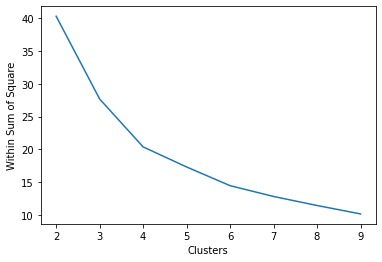

In [46]:
#shoulder method
inertias = []
for i in k:
    km = KMeans(n_clusters=i)
    km.fit(X)
    inertias.append(km.inertia_)
plt.plot(k, inertias)
plt.xlabel("Clusters")
plt.ylabel("Within Sum of Square")
plt.show()

Based on shillouette and elbow method, we decided to have 5 clusters.

In [47]:
#simple clusters into five groups based on two logs using Agglomerative Clustering
porosity_model =  AgglomerativeClustering(n_clusters=5)
wells_ready['RockType'] = porosity_model.fit_predict(X)
wells_ready.head(5)

,UWI,Depth,Gamma,Sonic,Density,Neutron,Resistivity,Caliper,Well,RockType
2849,11000075023501,2879.022800446,72.6428177837,71.4142692550,2.6123574194,0.1180197870,2.3050258358,NaN,HND-1,1
2850,11000075023501,2880.022800446,112.3658789597,77.6002909524,2.6469622251,0.2180352948,1.9510637326,NaN,HND-1,1
2851,11000075023501,2881.022800446,109.9691565187,79.4424376928,2.6281079666,0.1849587671,2.1360452241,NaN,HND-1,1
2852,11000075023501,2882.022800446,98.0089641029,73.3982360702,2.6193068073,0.1662170308,2.4452476504,NaN,HND-1,1
2853,11000075023501,2883.022800446,110.6091665270,80.4904032001,2.6466368633,0.1836244079,2.1875072091,NaN,HND-1,1


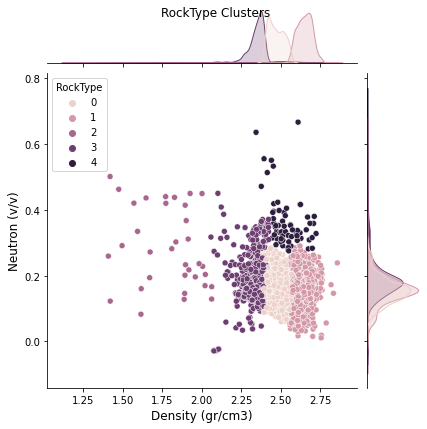

In [48]:
jp = sns.jointplot(data=wells_ready, x='Density' , y='Neutron', hue='RockType')
jp.fig.suptitle('RockType Clusters')
jp.set_axis_labels('Density (gr/cm3)', 'Neutron (v/v)', fontsize=12)
plt.show()

In [49]:
#simple clusters into five groups based on two logs using KMeans
porosity_model = KMeans(n_clusters=5, random_state=0)
wells_ready['Rocktype'] = porosity_model.fit_predict(X)
wells_ready.head(5)

,UWI,Depth,Gamma,Sonic,Density,Neutron,Resistivity,Caliper,Well,RockType,Rocktype
2849,11000075023501,2879.022800446,72.6428177837,71.4142692550,2.6123574194,0.1180197870,2.3050258358,NaN,HND-1,1,0
2850,11000075023501,2880.022800446,112.3658789597,77.6002909524,2.6469622251,0.2180352948,1.9510637326,NaN,HND-1,1,0
2851,11000075023501,2881.022800446,109.9691565187,79.4424376928,2.6281079666,0.1849587671,2.1360452241,NaN,HND-1,1,0
2852,11000075023501,2882.022800446,98.0089641029,73.3982360702,2.6193068073,0.1662170308,2.4452476504,NaN,HND-1,1,0
2853,11000075023501,2883.022800446,110.6091665270,80.4904032001,2.6466368633,0.1836244079,2.1875072091,NaN,HND-1,1,0


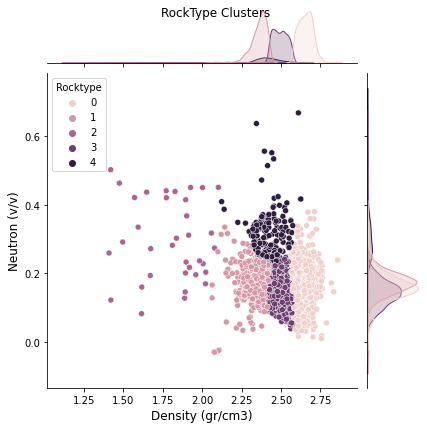

In [50]:
jp = sns.jointplot(data=wells_ready, x='Density' , y='Neutron', hue='Rocktype')
jp.fig.suptitle('RockType Clusters')
jp.set_axis_labels('Density (gr/cm3)', 'Neutron (v/v)', fontsize=12)
plt.show()

It seems that AgglomerativeClustering put more weigh on 'Density' variable. Thus, we decided to choose KMeans cluster to determine the rock type facies. The graph also shows that rocktype 0, 1, 3 is the best rocktype to store CO2 because it has higher porosity. Rocktype 2 probably shows coal interval, Rocktype 4 shows shale interval. It is also confirmed by looking at the log plot below.

In [51]:
wells_ready['RockType'] = porosity_model.predict(X)
wells_ready.head(5)

,UWI,Depth,Gamma,Sonic,Density,Neutron,Resistivity,Caliper,Well,RockType,Rocktype
2849,11000075023501,2879.022800446,72.6428177837,71.4142692550,2.6123574194,0.1180197870,2.3050258358,NaN,HND-1,0,0
2850,11000075023501,2880.022800446,112.3658789597,77.6002909524,2.6469622251,0.2180352948,1.9510637326,NaN,HND-1,0,0
2851,11000075023501,2881.022800446,109.9691565187,79.4424376928,2.6281079666,0.1849587671,2.1360452241,NaN,HND-1,0,0
2852,11000075023501,2882.022800446,98.0089641029,73.3982360702,2.6193068073,0.1662170308,2.4452476504,NaN,HND-1,0,0
2853,11000075023501,2883.022800446,110.6091665270,80.4904032001,2.6466368633,0.1836244079,2.1875072091,NaN,HND-1,0,0


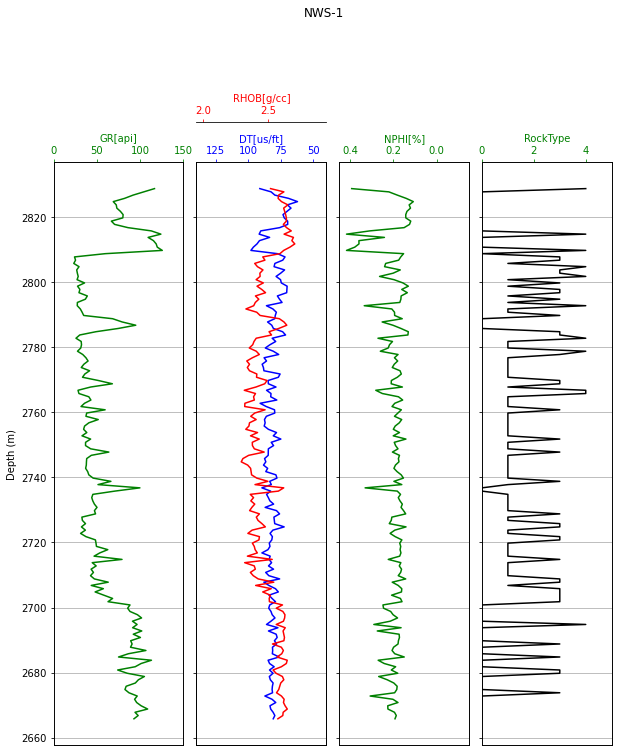

In [52]:
well_plot = wells_ready[wells_ready.Well=='NWS-1']
triple_combo_plot(well_plot)

In [53]:
#save model
joblib.dump(porosity_model, "porosity_model.joblib")

#load model
# porosity_model = joblib.load("porosity_model.joblib")

['porosity_model.joblib']

### Determine Salt Structure in Seismic - Supervised ML

We use a pair of dataset, raw seismic line and also masked seismic line which includes the salt structure interpretation.

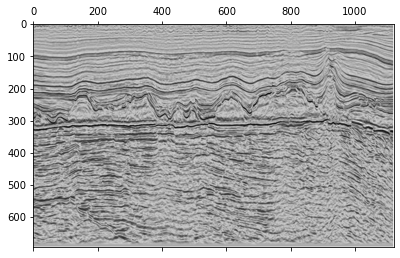

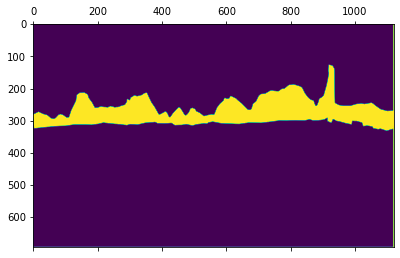

In [54]:
clean = mpimg.imread('segy/Section3_clean.tiff')
clean = clean[:,:,:1]/255

masked = mpimg.imread('segy/Section3_masked.tiff').copy()
masked = (masked-masked.min())/(masked.max()-masked.min())
masked = masked[:,:,0]

plt.matshow(clean[:,:,0], interpolation='spline16', cmap=plt.cm.gray, aspect=1)
plt.matshow(masked, interpolation='spline16', aspect=1)

In [55]:
number_train = 5000                             # Number of training examples
number_val   = 1000                             # Number of validation examples
dim          = (64,64,3)                        # Size of examples

#'crop' images to smaller batch images
def patchify(data, mask, patch_num, dim):

  X = np.empty((patch_num, *dim))
  y = np.empty((patch_num,2))

  (t_max, x_max, _) = data.shape

  for n in range(patch_num):
      
      # Select random point in data (not at the edge)   
      x_n = random.randint(dim[1]//2,x_max-dim[1]//2)
      t_n = random.randint(dim[0]//2,t_max-dim[0]//2)
      
      # Extract data patch around point   
      X[n,:,:,0] = data[t_n-dim[0]//2:t_n+dim[0]//2,x_n-dim[1]//2:x_n+dim[1]//2,0]
      
      # Note label of point (one-hot-encoding)   
      y[n,0] = mask[t_n,x_n]
      y[n,1] = 1 - mask[t_n,x_n]

  return X, y

X_train, y_train = patchify(clean[:,:500], masked[:,:500], number_train, dim)
X_val,   y_val   = patchify(clean[:,500:], masked[:,500:], number_val, dim)

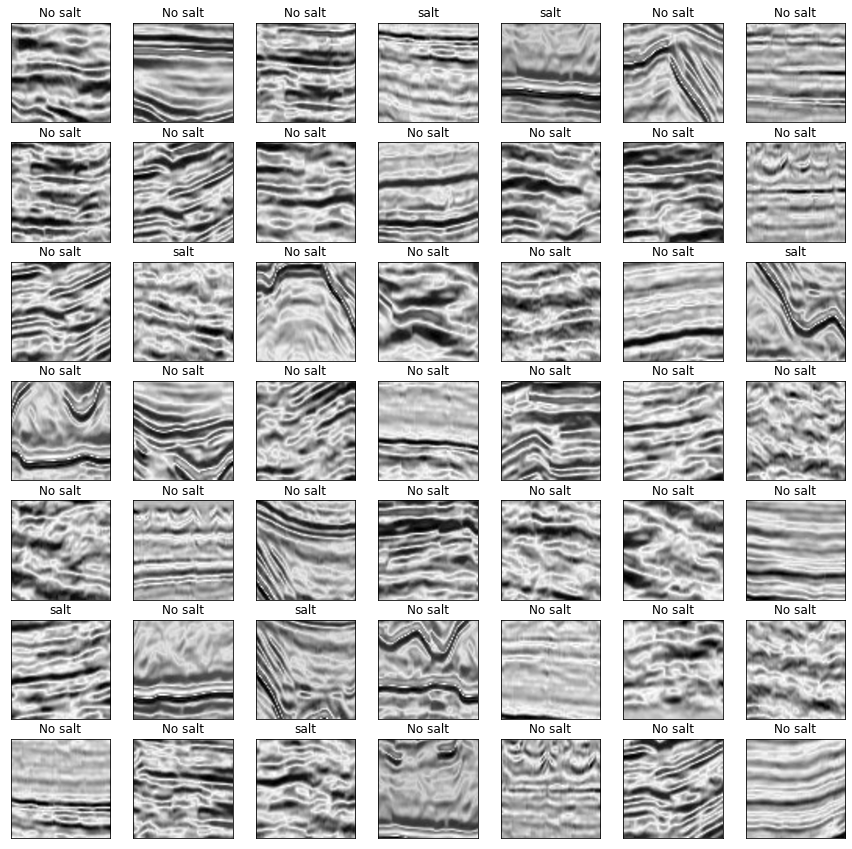

In [56]:
fig, axs = plt.subplots(7, 7, figsize=(15,15))

k = 0
for n in range(7):
  for m in range(7):
    axs[n,m].imshow(X_train[k,:,:,0], interpolation='spline16', cmap=plt.cm.gray, aspect=1)
    axs[n,m].set_xticks([])
    axs[n,m].set_yticks([])
    k += 1
    if y_train[k,0] == 1:
      axs[n,m].set_title('salt')
    else:
      axs[n,m].set_title('No salt')

Most of the patched data are dominated by non salt image which shows that we will train the model in imbalanced dataset. This might influence the result

In [57]:
#Build model using CNN
model = Sequential([Conv2D(16, 3, padding='same', activation='relu', input_shape=dim),
                    MaxPooling2D(),
                    Dropout(0.2),
                    Conv2D(32, 3, padding='same', activation='relu'),
                    MaxPooling2D(),
                    Dropout(0.2),
                    Conv2D(64, 3, padding='same', activation='relu'),
                    MaxPooling2D(),
                    Dropout(0.2),
                    Flatten(),
                    Dense(512, activation='relu'),
                    Dense(2, activation='softmax')])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 32)        0

In [58]:
#training data
history = model.fit(X_train, 
                    y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=10)

Epoch 1/10
157/157 [==============================] - 18s 106ms/step - loss: 0.3088 - binary_accuracy: 0.9056 - val_loss: 0.3307 - val_binary_accuracy: 0.8690
Epoch 2/10
157/157 [==============================] - 16s 103ms/step - loss: 0.1859 - binary_accuracy: 0.9322 - val_loss: 0.2245 - val_binary_accuracy: 0.9170
Epoch 3/10
157/157 [==============================] - 16s 101ms/step - loss: 0.0782 - binary_accuracy: 0.9680 - val_loss: 0.1920 - val_binary_accuracy: 0.9150
Epoch 4/10
157/157 [==============================] - 17s 107ms/step - loss: 0.0506 - binary_accuracy: 0.9792 - val_loss: 0.2216 - val_binary_accuracy: 0.8970
Epoch 5/10
157/157 [==============================] - 17s 108ms/step - loss: 0.0392 - binary_accuracy: 0.9814 - val_loss: 0.2091 - val_binary_accuracy: 0.9250
Epoch 6/10
157/157 [==============================] - 18s 116ms/step - loss: 0.0282 - binary_accuracy: 0.9856 - val_loss: 0.2448 - val_binary_accuracy: 0.9180
Epoch 7/10
157/157 [==========================

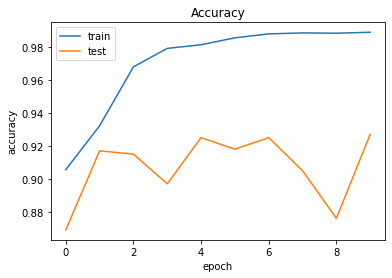

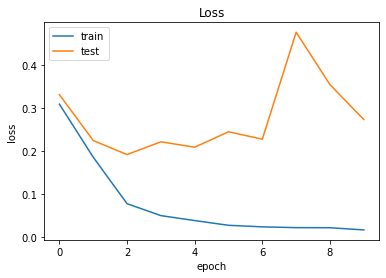

In [59]:
#plotting accuracy
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

The accuracy in test data does not show a smooth transition to a higher accuracy.

32/32 [==============================] - 1s 16ms/step


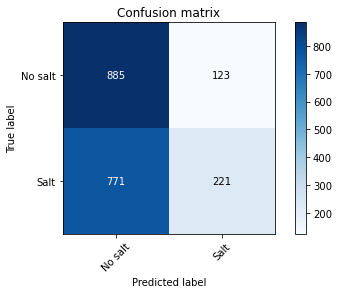

In [60]:
#plotting confusion matrix
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                    ha="center", va='center',
                    color="white" if cm[i, j] > thresh else "black")



y_true = y_val
y_pred = model.predict(X_val)

cm = confusion_matrix(y_true.astype(int)[:,0], y_pred.astype(int)[:,0]) + np.fliplr(confusion_matrix(y_true.astype(int)[:,1], y_pred.astype(int)[:,1]))
   
plot_confusion_matrix(cm, ['No salt', 'Salt'])

Although the test accuracy can reach 93% the model seems 'smelly' because based on confusion matrix the model can predict the non-salt interval better than salt interval!

99

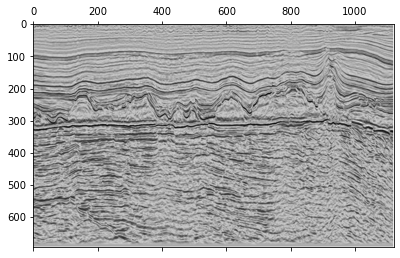

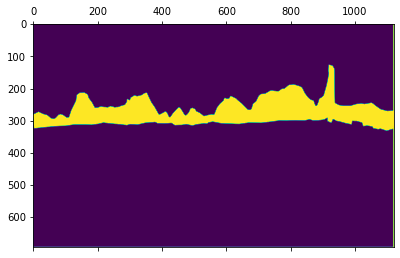

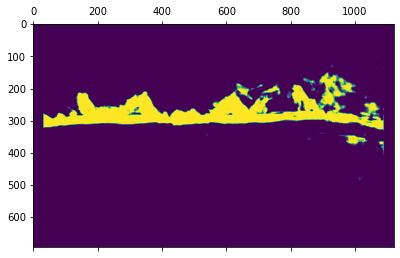

In [61]:
(t_max, x_max, _) = clean.shape
result            = np.zeros((t_max,x_max,2))
batch             = np.zeros((t_max-dim[1], *dim))

m = 0
n = 0
for x in range(dim[0]//2,x_max-dim[0]//2): 
  stdout.write("\r%d" % m)
  stdout.flush()
  m = m + 100/(x_max-dim[0])

  for t in range(dim[1]//2,t_max-dim[1]//2):
    batch[n,:,:,0] = clean[t-dim[1]//2:t+dim[1]//2, x-dim[0]//2:x+dim[0]//2, 0] 
    n = n + 1

  result[dim[1]//2:t_max-dim[1]//2,x,:] = model.predict_on_batch(batch)
  n = 0

plt.matshow(clean[:,:,0], interpolation='spline16', cmap=plt.cm.gray, aspect=1)
plt.matshow(masked, interpolation='spline16', aspect=1)
plt.matshow(result[:,:,0], interpolation='spline16', aspect=1)
plt.show()

It can detect the interval where the salt is but it has difficulties to define the exact shape of the salt structure.

In [62]:
#Let's see if we can tune some parameters, added another layer and change classifier to sigmoid
model2 = Sequential([Conv2D(16, 3, padding='same', activation='relu', input_shape=dim),
                    MaxPooling2D(),
                    Dropout(0.2),
                    Conv2D(32, 3, padding='same', activation='relu'),
                    MaxPooling2D(),
                    Dropout(0.2),
                    Conv2D(64, 3, padding='same', activation='relu'),
                    MaxPooling2D(),
                    Dropout(0.2),
                    Flatten(),
                    Dense(512, activation='relu'),
                    Dense(2, activation='sigmoid')])

model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 32, 32, 16)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 16, 16, 32)       

In [63]:
#training new model
history = model2.fit(X_train, 
                    y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=10)

Epoch 1/10
157/157 [==============================] - 18s 110ms/step - loss: 0.3185 - binary_accuracy: 0.9009 - val_loss: 0.3782 - val_binary_accuracy: 0.8690
Epoch 2/10
157/157 [==============================] - 16s 105ms/step - loss: 0.2632 - binary_accuracy: 0.9164 - val_loss: 0.3013 - val_binary_accuracy: 0.8950
Epoch 3/10
157/157 [==============================] - 17s 109ms/step - loss: 0.1387 - binary_accuracy: 0.9523 - val_loss: 0.2034 - val_binary_accuracy: 0.9165
Epoch 4/10
157/157 [==============================] - 19s 119ms/step - loss: 0.0721 - binary_accuracy: 0.9735 - val_loss: 0.1943 - val_binary_accuracy: 0.9190
Epoch 5/10
157/157 [==============================] - 18s 114ms/step - loss: 0.0516 - binary_accuracy: 0.9788 - val_loss: 0.2089 - val_binary_accuracy: 0.9195
Epoch 6/10
157/157 [==============================] - 18s 112ms/step - loss: 0.0384 - binary_accuracy: 0.9833 - val_loss: 0.2235 - val_binary_accuracy: 0.9260
Epoch 7/10
157/157 [==========================

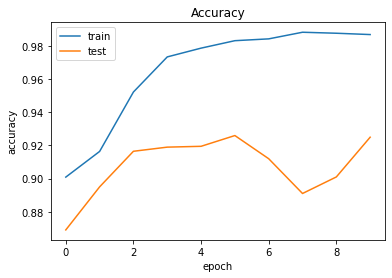

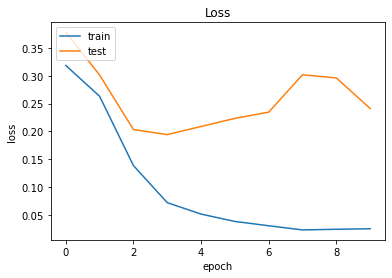

In [64]:
#plot accuracy and loss
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

32/32 [==============================] - 1s 16ms/step


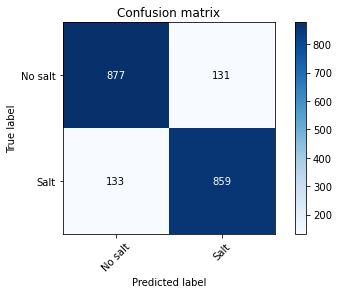

In [65]:
#plot confusion matrix
y_true = y_val
y_pred = model2.predict(X_val)

cm = confusion_matrix(y_true.astype(int)[:,0], y_pred.astype(int)[:,0]) + np.fliplr(confusion_matrix(y_true.astype(int)[:,1], y_pred.astype(int)[:,1]))
   
plot_confusion_matrix(cm, ['No salt', 'Salt'])

The accuracy on test data shows about 93% accuracy but the confusion matrix shows relatively better prediction than previous model.

99

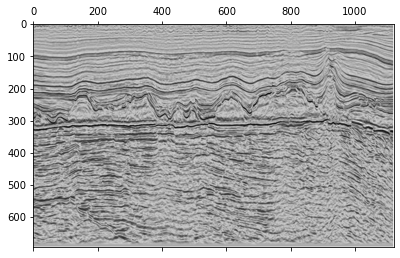

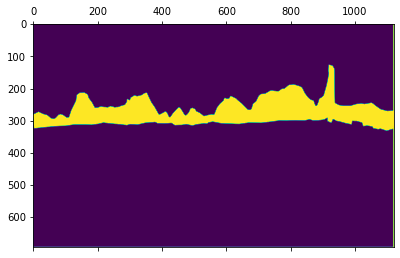

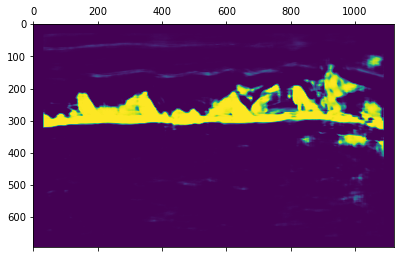

In [66]:
#Plot the result
(t_max, x_max, _) = clean.shape
result            = np.zeros((t_max,x_max,2))
batch             = np.zeros((t_max-dim[1], *dim))

m = 0
n = 0
for x in range(dim[0]//2,x_max-dim[0]//2): 
  stdout.write("\r%d" % m)
  stdout.flush()
  m = m + 100/(x_max-dim[0])

  for t in range(dim[1]//2,t_max-dim[1]//2):
    batch[n,:,:,0] = clean[t-dim[1]//2:t+dim[1]//2, x-dim[0]//2:x+dim[0]//2, 0] 
    n = n + 1

  result[dim[1]//2:t_max-dim[1]//2,x,:] = model2.predict_on_batch(batch)
  n = 0

plt.matshow(clean[:,:,0], interpolation='spline16', cmap=plt.cm.gray, aspect=1)
plt.matshow(masked, interpolation='spline16', aspect=1)
plt.matshow(result[:,:,0], interpolation='spline16', aspect=1)
plt.show()

It makes a better prediction on the seismic but it still struggle to delineate the shape of diapir on the right side. 

In [67]:
#save model
model2.save('salt_model')

# from tensorflow import keras
# model2 = keras.models.load_model('salt_model')

INFO:tensorflow:Assets written to: salt_model\assets


INFO:tensorflow:Assets written to: salt_model\assets


## **Result**

array([[<AxesSubplot:ylabel='HND-1'>, <AxesSubplot:ylabel='KWR-1A'>,
        <AxesSubplot:ylabel='LNB-1'>],
       [<AxesSubplot:ylabel='MLA-1'>, <AxesSubplot:ylabel='NWS-1'>,
        <AxesSubplot:ylabel='OPK-4A'>],
       [<AxesSubplot:ylabel='RDW-1'>, <AxesSubplot:ylabel='ROD-101'>,
        <AxesSubplot:ylabel='SSM-2'>],
       [<AxesSubplot:ylabel='UHM-1A'>, <AxesSubplot:ylabel='WSM-1'>,
        <AxesSubplot:ylabel='ZND-1'>]], dtype=object)

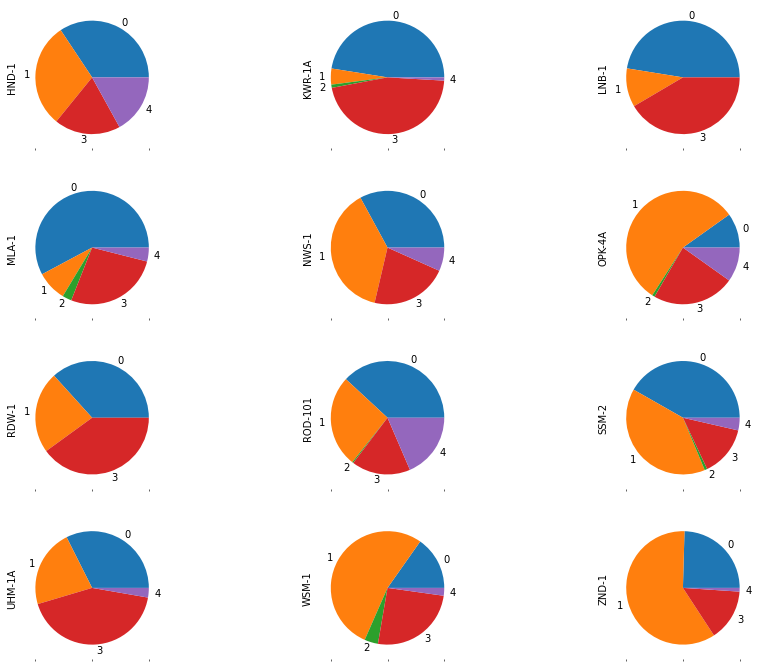

In [68]:
#Pie chart of rock type for each wells
wells_ready.groupby(['RockType', 'Well']).size().unstack(fill_value=0).plot.pie(subplots=True, sharex=True, layout=(4,3), legend=False, figsize=(15, 12))

The pie chart shows that UHM-1A has the most of rocktype 0, 1, 3 which indicates that the well has the best reservoir property to store CO2.

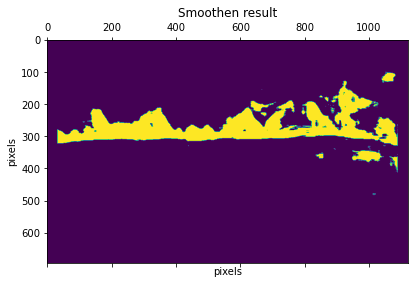

In [69]:
#'smooth' result from previous prediction to make a sharper boundary between salt and non-salt
result_smooth = (result[:,:,0]>0.5).astype(int)
plt.matshow(result_smooth, interpolation='spline16', aspect=1)
plt.title('Smoothen result')
plt.xlabel('pixels')
plt.ylabel('pixels')
plt.show()

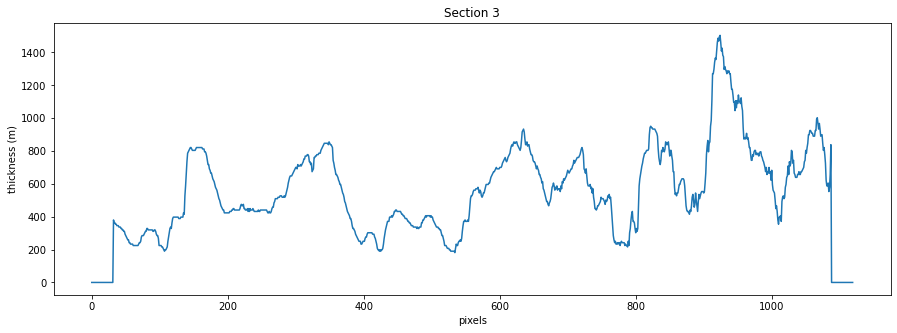

In [71]:
#make a dummy thickness calculation by counting salt pixels and convert it to meter
thickness = (np.count_nonzero(result_smooth > 0, axis=0))/result_smooth.shape[0]*6000

plt.figure(figsize=(15,5))
plt.plot(thickness)
plt.title('Section 3')
plt.xlabel('pixels')
plt.ylabel('thickness (m)')
plt.show()

In [72]:
np.savetxt('thickness.txt', thickness, fmt='%d')

Not a good way to measure a thickness actually since we measure 'interlayered' salt as one body. But we can improve this later.

Now we try to combine well properties with the salt thickness in this section and look which well will be the best candidate.

### **Combining both well and seismic data**

In [75]:
well_sect3 = ['HND-1','ZND-1','WSM-1','RDW-1'] #well located along section 3
well_sect3_dist = np.array([1000,8867.4,23089.1,26515]) #well distance in m to the edge of seismic line
well_sect3_dist_px = (well_sect3_dist / 27.5) #convert to pixel

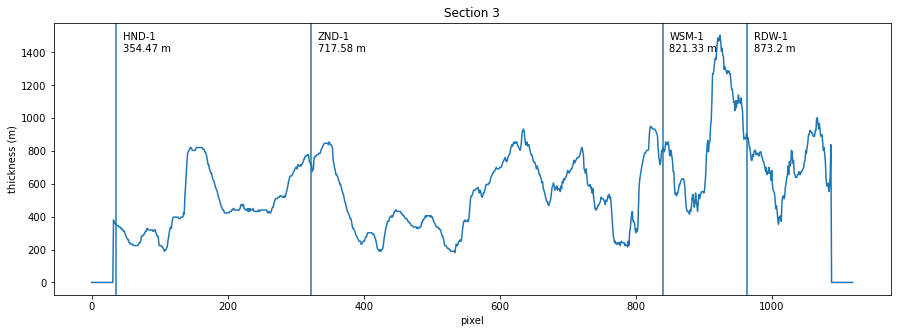

In [76]:
thickness_at_well = [thickness[round(i)] for i in well_sect3_dist_px] #gather thickness of salt on each well

#plot wells along section
plt.figure(figsize=(15,5))
plt.plot(thickness)
plt.title('Section 3')
plt.ylabel('thickness (m)')
plt.xlabel('pixel')
for i in range(len(well_sect3)):
    plt.axvline(well_sect3_dist_px[i])
    plt.text(well_sect3_dist_px[i]+10,thickness.max()-100,well_sect3[i]+'\n'+str(round(thickness_at_well[i],2))+' m',rotation=0)
plt.show()

Text(0.5, 1.0, 'RocktType Proportion')

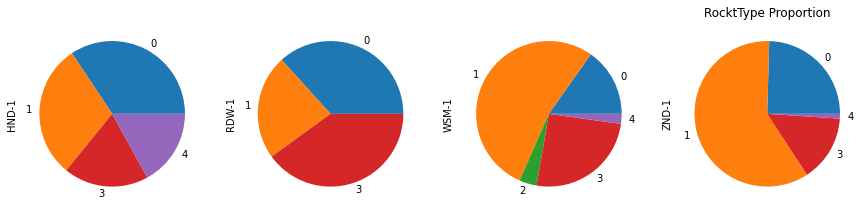

In [77]:
#Looking at the rock properties
well_prop_sect3 = wells_ready[wells_ready.Well.isin(well_sect3)].groupby(['RockType', 'Well']).size().unstack(fill_value=0)
well_prop_sect3.plot.pie(subplots=True, sharex=True, legend=False, figsize=(15, 4))
plt.title('RocktType Proportion')

In [78]:
#convert to rock type percentage
well_prop_sect3[well_prop_sect3.columns] = well_prop_sect3[well_prop_sect3.columns].div(well_prop_sect3[well_prop_sect3.columns].sum(axis=1), axis=0).multiply(100)

#assign salt thickness to the dataframe
well_prop_sect3 = well_prop_sect3.T
for i in range(len(well_sect3)):
  well_prop_sect3.loc[well_prop_sect3.index == well_sect3[i], 'Salt'] = thickness_at_well[i]

well_prop_sect3.head(5)

RockType,0,1,2,3,4,Salt
Well,,,,,,
HND-1,26.8436578171,15.2215799615,0.0,15.7232704403,80.3571428571,354.4668587896
RDW-1,36.2831858407,15.0289017341,0.0,42.1383647799,0.0000000000,873.1988472622
WSM-1,16.2241887906,36.9942196532,100.0,28.9308176101,14.2857142857,821.3256484150
ZND-1,20.6489675516,32.7552986513,0.0,13.2075471698,5.3571428571,717.5792507205


In [79]:
#Combine preferred Rocktype 0,1,3
well_prop_sect3 = well_prop_sect3.assign(RockType_pref = well_prop_sect3[0]+well_prop_sect3[1]+well_prop_sect3[3])

#Rank all wells based on preferred rock property and salt thickness
well_prop_sect3['Rank'] = well_prop_sect3[['RockType_pref','Salt']].apply(tuple,axis=1).rank(method='dense',ascending=False).astype(int)
well_prop_sect3.sort_values("Rank")

RockType,0,1,2,3,4,Salt,RockType_pref,Rank
Well,,,,,,,,
RDW-1,36.2831858407,15.0289017341,0.0,42.1383647799,0.0000000000,873.1988472622,93.4504523547,1
WSM-1,16.2241887906,36.9942196532,100.0,28.9308176101,14.2857142857,821.3256484150,82.1492260538,2
ZND-1,20.6489675516,32.7552986513,0.0,13.2075471698,5.3571428571,717.5792507205,66.6118133727,3
HND-1,26.8436578171,15.2215799615,0.0,15.7232704403,80.3571428571,354.4668587896,57.7885082188,4


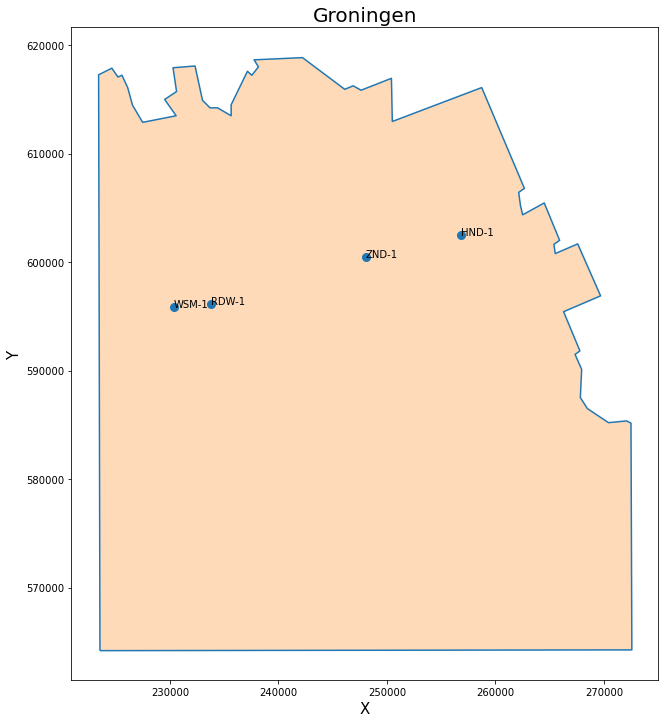

In [81]:
mapdf = gpd.read_file('Groningen_Field.zip')
well_location = pd.read_csv('well_location.csv')
well_location_sect3 = well_location[well_location.Name.isin(well_sect3)]
fig, ax = plt.subplots(figsize=(12,12))
mapdf.plot(ax=ax,facecolor='peachpuff')
ax.plot(well_location_sect3['Surface X'], well_location_sect3['Surface Y'], marker='o', linestyle='', ms=8, label=name)
plt.title('Groningen', fontsize=20)
plt.xlabel('X', fontsize=15)
plt.ylabel('Y', fontsize=15)
for i, txt in enumerate(well_sect3):
    ax.annotate(well_location_sect3['Name'].values[i], (well_location_sect3['Surface X'].values[i], well_location_sect3['Surface Y'].values[i]))

Based on the result, well RDW-1 is the most preferred well considering the Rotliegend Fm. property and also the availability of salt cap above the interval.

## **Discussion about domain implication**

The unsupervised ML method to cluster reservoir quality and know the percentage of each rock type is applicable and fast enough to give a first impression of the field compared to classic step-by-step petrophysical method, although this method does not offer exact quantitative value of how porous the reservoirs are. This method can assist the proccess especially for Groningen Basin where the field has hundreds wells. A scrappable website by Netherland Oil and Gas Data Center which store formation tops is also helpful to automate the whole process. There is an opportunity to improve this because there are inconsistencies between data gathered from scraping website and from petrel which I think it needs to be synchronized.

The supervised ML method to define salt facies works quite well, although it is open to some improvements, such as: utilizing 3D seismic data, seismic attributes, controling training data to have more balanced salt-non salt reference. 3D seismic can offer a better spatial understanding of the field although it will cost the time to train the model. I tried to apply the model to another seismic line excluded in the training phase, however my computer does not have enough capacity to run on another image (error dead kernel). I need more time to figure this out. This method is acceptable to determine wide salt structure such as salt dome but still need refinement to define narrow salt diapir. On the other hand, the supervised ML method can be utilized to fill missing log data, comparable to the Gardner method (in this case, Gardner does not work really well).

In terms of deciding which part is the best to store CO2, subject matter experts are still needed to decide which rocktype are the best. This workflow also does not consider the possibility of large/thick salt cap other than those penetrated by wells.

## **Conclusion**
Some of ML methods are widely implemented in geoscience. In this case, ML for seismic data currently can only be applied for reconnaissance study. Incorporates ML in the workflows can help to get an insight of our data faster, especially to determine the reservoir quality. To get exact location on where a good prospect for CCS reservoir, further examinations are needed.


## **References**
Seismic classification (https://github.com/thilowrona/seismic_deep_learning/blob/master/tutorial-01/tutorial-1.ipynb)  
  
  https://www.nlog.nl/datacenter/  
  
https://public.yoda.uu.nl/geo/UU01/1QH0MW.html